In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [81]:
# Load CSV
df = pd.read_csv('/content/spam.csv', encoding='latin-1')  # if encoding issue occurs
df = df[['Category', 'Message']]  # Keep only useful columns

# Rename for ease
df.columns = ['label', 'text']
df.dropna(inplace=True)

# Map labels
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print(df.head())
print(df['label'].value_counts())


   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
label
0    4825
1     747
Name: count, dtype: int64


In [82]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['clean_text'] = df['text'].apply(clean_text)


In [83]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove links
    text = re.sub(r'\@w+|\#','', text)  # remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()


,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [84]:
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)
X_tfidf = tfidf.fit_transform(df['clean_text']).toarray()


In [85]:
# Already numeric labels
y = df['label'].values

# Standardizing TF-IDF data (not necessary for LR, but for SVM etc.)
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_tfidf)


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [87]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

✅ Accuracy: 98.48 %

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.93      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115



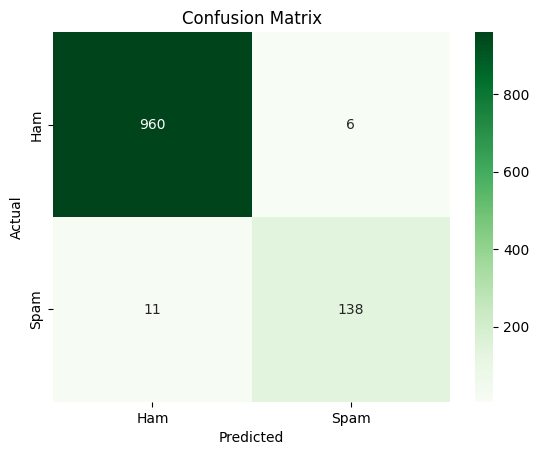

In [88]:
y_pred = model.predict(X_test)

print("✅ Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [89]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("📌 Best Params:", grid.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
📌 Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [90]:
def predict_message(msg):
    cleaned = clean_text(msg)
    tfidf_vec = tfidf.transform([cleaned])
    tfidf_vec_scaled = scaler.transform(tfidf_vec)
    prediction = best_model.predict(tfidf_vec_scaled)[0]
    return "Spam" if prediction == 1 else "Ham"

# Input Loop
while True:
    msg = input("📩 Enter message (type 'exit' to quit): ")
    if msg.lower() == 'exit':
        print("👋 Exiting...")
        break
    print("🧠 Prediction:", predict_message(msg))


📩 Enter message (type 'exit' to quit): Hey Member!  Shelby sent you a message and a key to unlock her private video gallery 🔥   Click here now  Enjoy!  xoxoxoxo
🧠 Prediction: Spam
📩 Enter message (type 'exit' to quit): Hey Member!  Angelica SWIPED RIGHT (27 years old, brown hair, brown eyes, aerobics instructor, within 11 miles of you)  she invited you to meet 🔥   Click here now to view her profile and respond   Send her a message and see if you like her enough to meet her in person!  If so, have fun! If not, don't worry, there are tons of other hot members near you.  Next time I'll try to find you someone who you'll like better :)  xoxoxoxo,
🧠 Prediction: Ham
📩 Enter message (type 'exit' to quit): Activate Your One Month Premium Dating Membership 💕  Click the link below to activate your VIP membership.   Send unlimited messages to thousands of lonely and horny singles within miles of you who are looking for casual dates, one night stands, and no strings hookups.   You know them from w

KeyboardInterrupt: Interrupted by user